In [53]:
import numpy as np
import sklearn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler

from tslearn.datasets import UCR_UEA_datasets
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D



In [117]:
# Implement methods required by DataLoader
class UCRDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label


# Define the CNN Model
class BasicCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)  # 1 input channel (grayscale), 32 output channels
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduce size by half
        self.fc1 = nn.Linear(64 * 71, 128)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        self.features = x  # Save the features before flattening for Grad-CAM
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

# Training Loop
def train(model, loader, criterion, optimizer, device, num_epochs = 20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(loader):.4f}")


# Test Function
def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += 1
            correct += (predicted == torch.max(labels.reshape(1, -1), 1)[1]).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


# Classification Function
def classify(model, sample, device):
    model.eval()
    with torch.no_grad():
        image = torch.from_numpy(sample[0]).to(device).unsqueeze(0)  # Add batch dimension
        output = model(image)

        predicted = np.zeros(len(sample[1]))
        _, ind = torch.max(output, 1)
        predicted[ind] = 1.0
    return predicted


# Plot single Time Series with Label
def plot_ts(ts_sample):
    ts, label = ts_sample
    plt.figure(figsize=(10, 4))
    plt.plot(ts[0], label="Time Series", color='blue')
    plt.title(f"Time Series Plot (Class Label: {label})")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()


# Plot all Time Series
def plot_all_ts(test_dataset):
    plt.figure(figsize=(10, 4))
    for item in test_dataset:
        ts, label = item
        color = 'blue' if label[0] == 1 else 'orange'
        plt.plot(ts[0], label="Time Series", color=color)
    plt.title(f"All Time Series")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()


def scale_dataset(traindata, testdata):
    minmaxscaler = MinMaxScaler()
    minmaxscaler.fit(traindata.reshape(-1, 1))

    scaled_traindata = minmaxscaler.transform(traindata.reshape(-1, 1)).reshape(-1, 286, 1)
    scaled_testdata = minmaxscaler.transform(testdata.reshape(-1, 1)).reshape(-1, 286, 1)
    return scaled_traindata, scaled_testdata

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BasicCNN(num_classes=2).to(device)

In [4]:
summary(model, (1, 286))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 286]             128
         MaxPool1d-2              [-1, 32, 143]               0
            Conv1d-3              [-1, 64, 143]           6,208
         MaxPool1d-4               [-1, 64, 71]               0
            Linear-5                  [-1, 128]         581,760
            Linear-6                    [-1, 2]             258
Total params: 588,354
Trainable params: 588,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 2.24
Estimated Total Size (MB): 2.46
----------------------------------------------------------------


In [112]:
dataset='Coffee'
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)

In [121]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

# Data Preparation (using MNIST as an example)

train_x, train_y, test_x, test_y=UCR_UEA_datasets().load_dataset("Coffee")

# Scale dataset
train_x, test_x = scale_dataset(train_x, test_x)

train_x = train_x.reshape(-1, 1, train_x.shape[-2])
test_x = test_x.reshape(-1, 1, test_x.shape[-2])

enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))

train_dataset = UCRDataset(train_x.astype(np.float32),train_y.astype(np.float32))
test_dataset = UCRDataset(test_x.astype(np.float32),test_y.astype(np.float32))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [122]:
# Initialize the model, loss function, and optimizer
model = BasicCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
train(model, train_loader, criterion, optimizer, device, num_epochs=100)

Epoch [1/100], Loss: 0.7365
Epoch [2/100], Loss: 0.6956
Epoch [3/100], Loss: 0.6952
Epoch [4/100], Loss: 0.6963
Epoch [5/100], Loss: 0.6942
Epoch [6/100], Loss: 0.6924
Epoch [7/100], Loss: 0.6928
Epoch [8/100], Loss: 0.6976
Epoch [9/100], Loss: 0.6938
Epoch [10/100], Loss: 0.6940
Epoch [11/100], Loss: 0.6836
Epoch [12/100], Loss: 0.6482
Epoch [13/100], Loss: 0.6009
Epoch [14/100], Loss: 0.4816
Epoch [15/100], Loss: 0.3660
Epoch [16/100], Loss: 0.3233
Epoch [17/100], Loss: 0.2297
Epoch [18/100], Loss: 0.2099
Epoch [19/100], Loss: 0.1130
Epoch [20/100], Loss: 0.1352
Epoch [21/100], Loss: 0.0698
Epoch [22/100], Loss: 0.0502
Epoch [23/100], Loss: 0.0355
Epoch [24/100], Loss: 0.0308
Epoch [25/100], Loss: 0.0437
Epoch [26/100], Loss: 0.0249
Epoch [27/100], Loss: 0.0625
Epoch [28/100], Loss: 0.0208
Epoch [29/100], Loss: 0.0119
Epoch [30/100], Loss: 0.0102
Epoch [31/100], Loss: 0.0088
Epoch [32/100], Loss: 0.0098
Epoch [33/100], Loss: 0.0080
Epoch [34/100], Loss: 0.0068
Epoch [35/100], Loss: 0

In [123]:
# Testing
test(model, test_loader, device)

# Example Classification
# Assuming `example_image` is a single MNIST image preprocessed similarly to the training data
test_sample = test_dataset[15]
predicted_label = classify(model, test_sample, device)
print(f"Predicted Label: {predicted_label}")


Test Accuracy: 100.00%
Predicted Label: [0. 1.]


In [124]:
np.argmax(model(torch.from_numpy(test_x).float()).detach().numpy(), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [125]:
test_dataset.target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

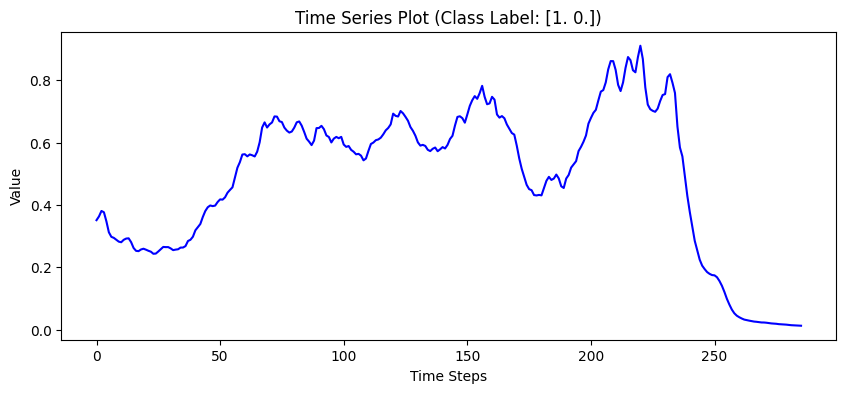

In [126]:
plot_ts(test_dataset[0])

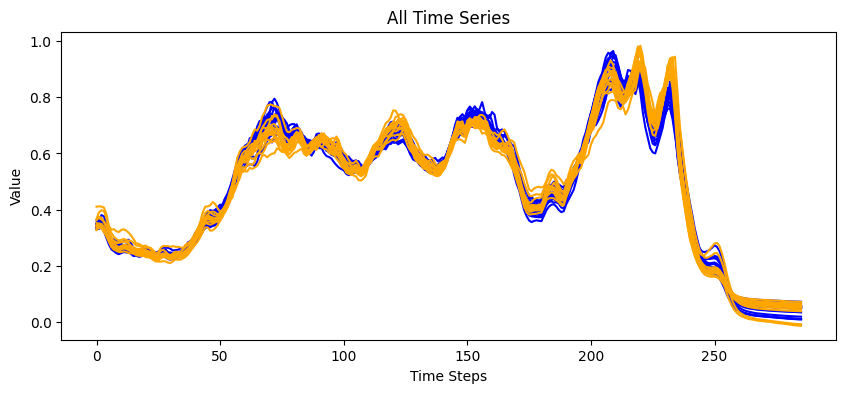

In [127]:
plot_all_ts(test_dataset)

In [128]:
def grad_cam(model, input_tensor, target_class):
    model.eval()  # Set model to evaluation mode

    # Create storage for gradients
    gradients = {}

    # Register hook to capture gradients from conv2
    def save_gradients(module, grad_in, grad_out):
        gradients["value"] = grad_out[0]

    # Hook the conv2 layer
    model.conv2.register_backward_hook(save_gradients)

    # Forward pass
    output = model(input_tensor)

    # Get the score for the target class
    score = output[:, target_class]

    # Backward pass to calculate gradients
    model.zero_grad()
    score.backward(retain_graph=True)

    # Extract gradients and feature maps
    activations = model.features.detach()  # Feature maps
    grads = gradients["value"].detach()  # Gradients w.r.t the feature maps

    # Compute weights (global average pooling of gradients)
    weights = torch.mean(grads, dim=2, keepdim=True)  # Average over time dimension

    # Compute Grad-CAM activation map
    grad_cam_map = torch.sum(weights * activations, dim=1).squeeze()  # Weighted sum of feature maps
    grad_cam_map = F.relu(grad_cam_map)  # Apply ReLU to keep only positive contributions

    # Upsample Grad-CAM map to match input size
    grad_cam_map = F.interpolate(
        grad_cam_map.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
        size=(input_tensor.size(2)),  # Match the input time series length
        mode="linear",
        align_corners=False,
    ).squeeze()  # Remove extra dimensions

    # Normalize the Grad-CAM map
    grad_cam_map = grad_cam_map - grad_cam_map.min()
    grad_cam_map = grad_cam_map / grad_cam_map.max()
    return grad_cam_map.cpu().numpy()


In [37]:
test_id = 0

input_tensor = torch.from_numpy(test_dataset[test_id][0]).to(device).unsqueeze(0)
target_class = 0 #np.argmax(test_dataset[17][1])

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


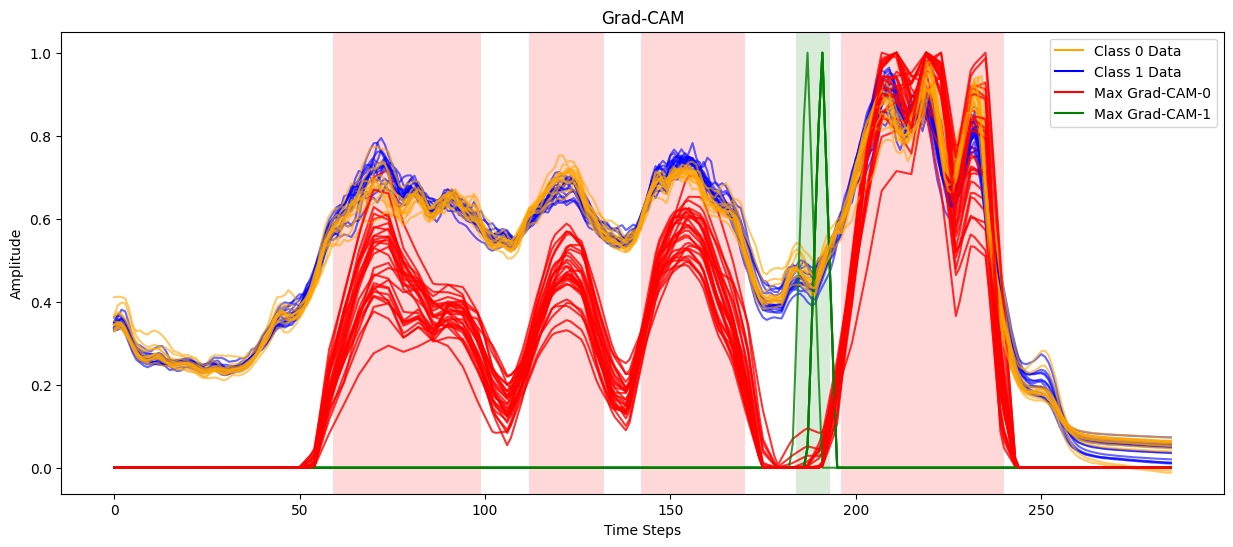

In [143]:
time_axis = np.arange(286)
plt.figure(figsize=(15, 6))

# Initialize arrays for Grad-CAM maxima
max_cam_0 = np.zeros_like(time_axis, dtype=float)
max_cam_1 = np.zeros_like(time_axis, dtype=float)

for sample in test_dataset:
    input_tensor = torch.from_numpy(sample[0]).to(device).unsqueeze(0)
    label = sample[1]

    # Visualization
    color = 'blue' if label[0] == 1 else 'orange'
    plt.plot(time_axis, input_tensor.squeeze().detach().numpy(), label="Input Time Series", color=color, alpha=0.6)

    # Compute Grad-CAM for class 0
    cam_0 = grad_cam(model, input_tensor, 0)
    max_cam_0 = np.fmax(max_cam_0, cam_0)
    plt.plot(time_axis, cam_0, alpha=0.8, label="Max Grad-CAM-0", color="red")

    # Compute Grad-CAM for class 1
    cam_1 = grad_cam(model, input_tensor, 1)
    max_cam_1 = np.fmax(max_cam_1, cam_1)
    plt.plot(time_axis, cam_1, alpha=0.8, label="Max Grad-CAM-1", color="green")

# Replace multiple Grad-CAM lines with their respective maxima
# plt.plot(time_axis, max_cam_0, alpha=0.8, label="Max Grad-CAM-0", color="red")
# plt.plot(time_axis, max_cam_1, alpha=0.8, label="Max Grad-CAM-1", color="green")

# Add grey shaded areas where Grad-CAM max values exceed the threshold
threshold = 0.35
above_threshold_0 = max_cam_0 > threshold
above_threshold_1 = max_cam_1 > threshold

# Combine the regions for shading
above_threshold = np.logical_or(above_threshold_0, above_threshold_1)

for i in range(1, len(time_axis)):
    if above_threshold_0[i]:
        plt.axvspan(time_axis[i - 1], time_axis[i], color='red', alpha=0.15, lw=0)

for i in range(1, len(time_axis)):
    if above_threshold_1[i]:
        plt.axvspan(time_axis[i - 1], time_axis[i], color='green', alpha=0.15, lw=0)

# Add title, labels, and legend
plt.title("Grad-CAM")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")

colors = ['orange', 'blue', 'red', 'green']
lines = [Line2D([0], [0], color=c) for c in colors]
labels = ['Class 0 Data', 'Class 1 Data', 'Max Grad-CAM-0', 'Max Grad-CAM-1']
plt.legend(lines, labels)

plt.show()


In [138]:
above_threshold_0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,